Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import seaborn as sns

#from sklearn.metrics import accuracy_score

# **Functions**

**Define Functions to plot data values and distribution**

In [ ]:
def plot_data(dataframe, x_column, columns_to_plot, fig_size=(16, 8), method='plotly', date_range=None):
    if date_range:
        start_date, end_date = date_range
        selected_df = dataframe[(dataframe[x_column] >= start_date) & (dataframe[x_column] <= end_date)]
    else:
        selected_df = dataframe

    min_val = selected_df[x_column].min()
    max_val = selected_df[x_column].max()
    title = f'Data Plot ({min_val} to {max_val})'

    if method == 'plotly':
        fig = px.line(selected_df, x=x_column, y=columns_to_plot, title=title)
        fig.show()
    elif method == 'seaborn':
        plt.figure(figsize=fig_size)
        for col in columns_to_plot:
            sns.lineplot(data=selected_df, x=x_column, y=col, label=col)
        plt.title(title)
        plt.legend()
        plt.show()

    elif method == 'matplotlib':
        plt.figure(figsize=fig_size)
        for col in columns_to_plot:
            plt.plot(selected_df[x_column], selected_df[col], label=col)
        plt.xlabel(x_column)
        plt.ylabel('Value')
        plt.title(title)
        plt.legend()
        plt.show()
    else:
        print("Invalid method. Supported methods are 'plotly', 'seaborn', and 'matplotlib'.")
'''
# Example usage for plotting specific date range:
columns_to_plot = ['Outdoor_Temp_°C', 'Outdoor_Humidity_%', 'Outdoor_Irradiance_W/m2', 'Indoor_Temp_°C', 'Indoor_Humidity_%', 'Power_W']
plot_data(merged_df, 'DateTime', columns_to_plot, fig_size=(10.0, 8.0), method='plotly', date_range=('2024-02-13', '2024-02-15'))

# Example usage for plotting entire dataset:
 plot_data(merged_df, 'DateTime', columns_to_plot, fig_size=(10.0, 8.0), method='plotly')
'''



def plot_distribution(df, columns_to_plot, plot_library='plotly'):
    """
    Plot distribution of specified columns in the DataFrame using the specified plotting library.

    Parameters:
        df (DataFrame): The DataFrame for which distribution is to be plotted.
        columns_to_plot (list): List of column names for which distribution is to be plotted.
        plot_library (str): Name of the plotting library to be used ('seaborn', 'matplotlib', or 'plotly').
    """
    for column in columns_to_plot:
        if plot_library == 'seaborn':
            sns.histplot(df[column], kde=True)
            plt.title(f'Distribution of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.show()
        elif plot_library == 'matplotlib':
            plt.hist(df[column], bins=30, color='skyblue', edgecolor='black')
            plt.title(f'Distribution of {column}')
            plt.xlabel(column)
            plt.ylabel('Frequency')
            plt.show()
        elif plot_library == 'plotly':
            fig = px.histogram(df, x=column, title=f'Distribution of {column}')
            fig.show()
        else:
            print(f"Plotting library '{plot_library}' is not supported.")

# Using scikitlearn


def calculate_metrics(y_true, y_pred):
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Calculate R-squared
    r_squared = r2_score(y_true, y_pred)

    # Calculate NMBE
    nmbe = (np.sum(y_pred - y_true) / (len(y_true) * np.mean(y_true))) * 100

    # Calculate MAE
    mae = mean_absolute_error(y_true, y_pred)

    return mae, rmse, r_squared, nmbe




# Using tensorflow

def calculate_metrics_tf(y_true, y_pred):
    y_true_tf = tf.convert_to_tensor(y_true, dtype=tf.float64)
    y_pred_tf = tf.convert_to_tensor(y_pred, dtype=tf.float64)

    # Calculate RMSE using TensorFlow
    mse_tf = tf.reduce_mean(tf.square(y_true_tf - y_pred_tf))
    rmse_tf = tf.sqrt(mse_tf)

    # Calculate R-squared using TensorFlow
    r_squared_tf = 1 - tf.reduce_sum(tf.square(y_true_tf - y_pred_tf)) / tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))

    # Calculate NMBE using TensorFlow
    nmbe_tf = ((tf.reduce_sum(tf.cast(y_pred_tf - y_true_tf, tf.float64)) / (tf.cast(tf.size(y_true_tf), tf.float64) * tf.reduce_mean(y_true_tf))) * 100)

    # Calculate MAE using TensorFlow
    mae_tf = tf.reduce_mean(tf.abs(y_pred_tf - y_true_tf))

    # Evaluate tensors
    rmse_result, r_squared_result, nmbe_result, mae_result = rmse_tf.numpy(), r_squared_tf.numpy(), nmbe_tf.numpy(), mae_tf.numpy()

    return mae_result, rmse_result, r_squared_result, nmbe_result


# **Load Data**

In [ ]:
# Load the dataset
dataFrame = pd.read_csv('/content/RA_Room_FinalCombined_60T_Simulation_Augmented_2023-01-01_to_2023-12-31.csv')
dataFrame.tail()

,DateTime,Day_of_year,Time_of_day,Time,Day_of_year_normalized,Time_of_day_normalized,Outdoor_Temp_°C,Outdoor_Humidity_%,Outdoor_SolarRadiation_W/m2,Indoor_Temp_°C,Indoor_Humidity_%,FloorNumber,Volume_of_Room_m3,AC_type,Rated_wattage,BTU,Energy_Efficiency_Ratio,Operating_state,Power_W
26275,2023-12-31 19:00:00,365,19,1140,0.997,0.792,26.225,91.917,0.0,25.538,95.808,3,111.31,0,2070,22000,3.09,1,5.0
26276,2023-12-31 20:00:00,365,20,1200,0.997,0.833,26.683,91.083,0.0,24.787,99.749,3,111.31,0,2070,22000,3.09,1,5.0
26277,2023-12-31 21:00:00,365,21,1260,0.997,0.875,25.892,94.417,0.0,23.797,100.000,3,111.31,0,2070,22000,3.09,1,5.0
26278,2023-12-31 22:00:00,365,22,1320,0.997,0.917,21.183,76.250,0.0,22.120,94.331,3,111.31,0,2070,22000,3.09,1,5.0
26279,2023-12-31 23:00:00,365,23,1380,0.997,0.958,15.000,50.000,0.0,20.380,58.328,3,111.31,0,2070,22000,3.09,1,5.0


In [ ]:
# Plot histogram
column = 'Outdoor_SolarRadiation_W/m2'
fig = px.histogram(dataFrame, x=column, nbins=100000, title=f'Histogram of {column}')
fig.show()

In [ ]:
plot_data(dataFrame, 'DateTime', ["Outdoor_SolarRadiation_W/m2"], fig_size=(10.0, 8.0), method='plotly')

##Remove Outliers

Outdoor_Temp_°C

In [ ]:
# Column for which we want to remove outliers
column = 'Outdoor_Temp_°C'
print(min(dataFrame[column]),max(dataFrame[column]))
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for the specified column
Q1 = dataFrame[column].quantile(0.25)
Q3 = dataFrame[column].quantile(0.75)
IQR = Q3 - Q1

# Define a threshold
threshold = 1.5

# Calculate the median of the specified column
median_value = dataFrame[column].median()

# Identify outliers
outliers = (dataFrame[column] < (Q1 - threshold * IQR)) | (dataFrame[column] > (Q3 + threshold * IQR))

# Replace outliers with the median
dataFrame.loc[outliers, column] = median_value

# Print the modified DataFrame
print(min(dataFrame[column]),max(dataFrame[column]))

15.0 34.683
20.642 34.683


In [ ]:

# Column for which we want to replace negative values
column = 'Outdoor_SolarRadiation_W/m2'

# Replace negative values with 0
dataFrame.loc[dataFrame[column] < 0, column] = 0

# Print the modified DataFrame
print(min(dataFrame[column]),max(dataFrame[column]))


0.0 1016.667


# **For loop for optimize**

In [ ]:
def plot_history(history,method ='plotly'):
  if method=='plotly':
    # Extracting training loss and validation loss from history
    train_loss = history.history['loss']
    validation_loss = history.history['val_loss']

    # Creating a DataFrame for plotting
    history_df = pd.DataFrame({'Epoch': range(1, len(train_loss) + 1),
                              'Training Loss': train_loss,
                              'Validation Loss': validation_loss})




    # Plotting the learning curve using Plotly Express
    fig = px.line(history_df, x='Epoch', y=['Training Loss', 'Validation Loss'],
                  labels={'value': 'Loss', 'variable': 'Loss Type'},
                  title='Learning Curve: Training and Validation Loss Over Epochs')
    fig.show()
  else:
    sns.lineplot(x=range(1, len(history.history['loss']) + 1), y=history.history['loss'], label="train loss")
    sns.lineplot(x=range(1, len(history.history['val_loss']) + 1), y=history.history['val_loss'], label="validation loss")
    plt.xlabel("epochs")
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def print_metrices():
  print()

  print("Final Validation MAE:", mae_validation, 'from tf:', mae_tf_validation)
  print("Final Validation RMSE:", rmse_validation, 'from tf:', rmse_tf_validation)
  print("Final Validation R-Squared:", r_squared_validation, 'from tf:', r_squared_tf_validation)
  print("Final Validation NMBE:", nmbe_validation, 'from tf:', nmbe_tf_validation)
  print()

  print("Final Test  MAE:", mae_test, 'from tf:', mae_tf_test)
  print("Final Test  RMSE:", rmse_test, 'from tf:', rmse_tf_test)
  print("Final Test  R-Squared:", r_squared_test, 'from tf:', r_squared_tf_test)
  print("Final Test  NMBE:", nmbe_test, 'from tf:', nmbe_tf_test)
  print()

**Data Sets with mixing**

In [ ]:
print("\n".join(dataFrame.columns))
dataFrame.shape

DateTime
Day_of_year
Time_of_day
Time
Day_of_year_normalized
Time_of_day_normalized
Outdoor_Temp_°C
Outdoor_Humidity_%
Outdoor_SolarRadiation_W/m2
Indoor_Temp_°C
Indoor_Humidity_%
FloorNumber
Volume_of_Room_m3
AC_type
Rated_wattage
BTU
Energy_Efficiency_Ratio
Operating_state
Power_W


(26280, 19)

In [ ]:

# Assuming dataFrame is your DataFrame containing the dataset

'''
without scaling operating state

# Columns to keep constant
constant_columns = ["Operating_state"]

# Separate constant columns
constant_df = dataFrame[constant_columns]

# Columns to scale
columns_to_scale = ["Time_of_day", 'Day_of_year', 'Outdoor_Temp_°C', 'Outdoor_Humidity_%', 'Outdoor_SolarRadiation_W/m2',
                    'Indoor_Temp_°C', 'Indoor_Humidity_%', "Volume_of_Room_m3", "Rated_wattage","Energy_Efficiency_Ratio", "BTU"]  # 'WindSpeed' ,"Time",


# Standardize the remaining columns
scaler = StandardScaler()
scaler.fit(dataFrame[columns_to_scale])
scaled_data = scaler.transform(dataFrame[columns_to_scale])
# Create a DataFrame with scaled data
scaled_df = pd.DataFrame(scaled_data, columns=columns_to_scale)

# Concatenate constant columns with scaled data
X = pd.concat([constant_df, scaled_df], axis=1)
'''
#-----------------------------------------------------------------------------------------------------------------------

# Columns to scale
columns_to_scale = ["Time_of_day", 'Day_of_year', 'Outdoor_Temp_°C', 'Outdoor_Humidity_%', 'Outdoor_SolarRadiation_W/m2',
                    'Indoor_Temp_°C', 'Indoor_Humidity_%', "Operating_state"]  # 'WindSpeed' ,"Time","Volume_of_Room_m3", "Rated_wattage","Energy_Efficiency_Ratio", "BTU",'AC_type','FloorNumber',




# Standardize the remaining columns
scaler = StandardScaler()
scaler.fit(dataFrame[columns_to_scale])
scaled_data = scaler.transform(dataFrame[columns_to_scale])
# Create a DataFrame with scaled data
X = pd.DataFrame(scaled_data, columns=columns_to_scale)


# Extract the target variable y
Y = dataFrame['Power_W']

# Split the data into training, validation, and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# Ensure the lengths of each set
train_length = len(X_train)
dev_length = len(X_dev)
test_length = len(X_test)

# Check the lengths of each set
print("Train set length:", train_length)
print("Dev set length:", dev_length)
print("Test set length:", test_length)


Train set length: 18396
Dev set length: 3942
Test set length: 3942


In [ ]:
X_train.head()

,Time_of_day,Day_of_year,Outdoor_Temp_°C,Outdoor_Humidity_%,Outdoor_SolarRadiation_W/m2,Indoor_Temp_°C,Indoor_Humidity_%,Operating_state
19537,-1.516862,-0.930091,-0.655834,0.855701,-0.730892,-1.173313,1.053208,0.021299
15685,0.216695,1.006017,1.529345,-1.757246,1.459450,1.587990,-1.706404,-1.219802
16248,-1.661325,1.233794,-1.006158,0.933299,-0.730892,-1.206283,1.053208,-1.219802
16435,1.083473,1.300229,0.387864,0.227656,-0.730892,0.320523,0.995958,-1.219802
23676,0.072232,0.702314,0.542621,-0.330607,2.090844,1.258972,-0.818408,0.021299


In [ ]:
Y_train.head()

19537    5.0
15685    0.0
16248    0.0
16435    0.0
23676    5.0
Name: Power_W, dtype: float64

##Model 1

In [ ]:
def train_model(X_train,Y_train,num_nodes_L1,num_nodes_L2,num_nodes_L3,learning_rate,batch_size,epochs):
  Model= tf.keras.Sequential([
    tf.keras.layers.Dense(num_nodes_L1, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(num_nodes_L2, activation='relu'),
    tf.keras.layers.Dense(num_nodes_L3, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
  ])

  optimizer = Adam(learning_rate = learning_rate)

  # Compile the model with mean absolute error as the loss function and MAE as a metric

  Model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])
  history = Model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_dev, Y_dev),verbose=0)
  return Model,history


With L2 Regularization

In [ ]:
from tensorflow.keras import regularizers



def train_model(X_train,Y_train,num_nodes_L1,num_nodes_L2,num_nodes_L3,learning_rate,batch_size,epochs,l2_regularization):
# Build the model with L2 regularization
  Model = tf.keras.Sequential([
    tf.keras.layers.Dense(num_nodes_L1, activation='relu', input_shape=(X_train.shape[1],),
                          kernel_regularizer=regularizers.l2(l2_regularization)),
    tf.keras.layers.Dense(num_nodes_L2, activation='relu',
                          kernel_regularizer=regularizers.l2(l2_regularization)),
    tf.keras.layers.Dense(num_nodes_L3, activation='relu',
                          kernel_regularizer=regularizers.l2(l2_regularization)),
    tf.keras.layers.Dense(1, activation='linear')
  ])

  optimizer = Adam(learning_rate = learning_rate)

  # Compile the model with mean absolute error as the loss function and MAE as a metric

  Model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])
  history = Model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_dev, Y_dev),verbose=0)
  return Model,history






with Dropout layers(One droput rate)

In [ ]:
def train_model(X_train, Y_train, num_nodes_L1, num_nodes_L2, num_nodes_L3, learning_rate, batch_size, epochs, dropout_rate=None):
    Model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_nodes_L1, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(dropout_rate) if dropout_rate is not None else tf.keras.layers.Flatten(),  # Add dropout or flatten layer
        tf.keras.layers.Dense(num_nodes_L2, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate) if dropout_rate is not None else tf.keras.layers.Flatten(),  # Add dropout or flatten layer
        tf.keras.layers.Dense(num_nodes_L3, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate) if dropout_rate is not None else tf.keras.layers.Flatten(),  # Add dropout or flatten layer
        tf.keras.layers.Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model with mean absolute error as the loss function and MAE as a metric
    Model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

    history = Model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_dev, Y_dev), verbose=0)

    return Model, history


With 3 Dropout rates(Define dropout for each layer)

In [ ]:
def train_model(X_train, Y_train, num_nodes_L1, num_nodes_L2, num_nodes_L3, learning_rate, batch_size, epochs, dropout_rate_L1=None, dropout_rate_L2=None, dropout_rate_L3=None):
    Model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_nodes_L1, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(dropout_rate_L1) if dropout_rate_L1 is not None else tf.keras.layers.Flatten(),  # Add dropout or flatten layer
        tf.keras.layers.Dense(num_nodes_L2, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate_L2) if dropout_rate_L2 is not None else tf.keras.layers.Flatten(),  # Add dropout or flatten layer
        tf.keras.layers.Dense(num_nodes_L3, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate_L3) if dropout_rate_L3 is not None else tf.keras.layers.Flatten(),  # Add dropout or flatten layer
        tf.keras.layers.Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model with mean absolute error as the loss function and MAE as a metric
    Model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

    history = Model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_dev, Y_dev), verbose=0)

    return Model, history


num_nodes_L1:300, num_nodes_L2:200, num_nodes_L3:25, learning_rate:0.01, batch_size:1000
124/124 [==============================] - 0s 2ms/step - loss: 33.8447 - mae: 33.8447


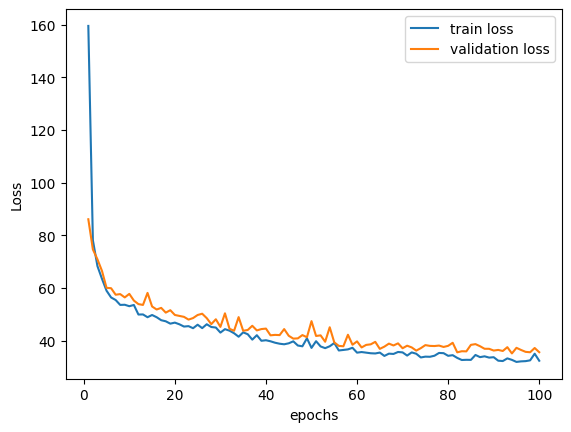

124/124 [==============================] - 0s 2ms/step

Final Validation MAE: 35.66032715966628 from tf: 35.660327159666274
Final Validation RMSE: 90.99793139463854 from tf: 90.99793139463854
Final Validation R-Squared: 0.9488068518914338 from tf: 0.9488068518914337
Final Validation NMBE: -2.6408762409110933 from tf: -2.6408762409110933

Final Test  MAE: 33.844709151075556 from tf: 33.844709151075556
Final Test  RMSE: 93.32511552228478 from tf: 93.32511552228478
Final Test  R-Squared: 0.9426890313328664 from tf: 0.9426890313328662
Final Test  NMBE: -2.177658572660578 from tf: -2.177658572660578



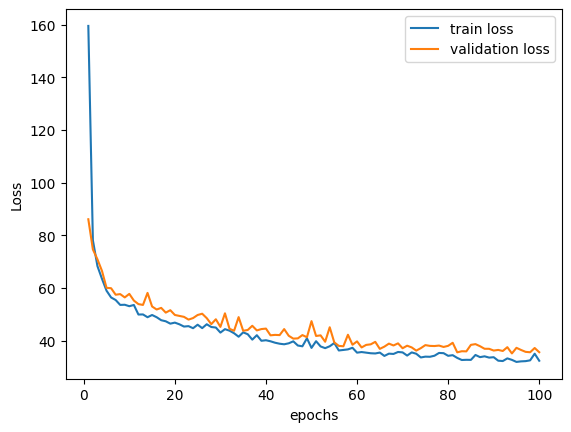

124/124 [==============================] - 0s 2ms/step

Final Validation MAE: 35.66032715966628 from tf: 35.660327159666274
Final Validation RMSE: 90.99793139463854 from tf: 90.99793139463854
Final Validation R-Squared: 0.9488068518914338 from tf: 0.9488068518914337
Final Validation NMBE: -2.6408762409110933 from tf: -2.6408762409110933

Final Test  MAE: 33.844709151075556 from tf: 33.844709151075556
Final Test  RMSE: 93.32511552228478 from tf: 93.32511552228478
Final Test  R-Squared: 0.9426890313328664 from tf: 0.9426890313328662
Final Test  NMBE: -2.177658572660578 from tf: -2.177658572660578

******************************************************************************************************************************************************
num_nodes_L1:300, num_nodes_L2:200, num_nodes_L3:30, learning_rate:0.01, batch_size:1000
124/124 [==============================] - 0s 2ms/step - loss: 34.2255 - mae: 34.2255
***********************************************************************

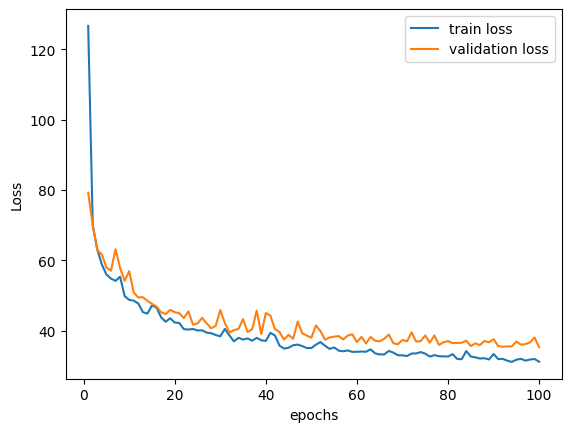

124/124 [==============================] - 0s 2ms/step

Final Validation MAE: 35.2853209425896 from tf: 35.2853209425896
Final Validation RMSE: 88.89185448225177 from tf: 88.89185448225186
Final Validation R-Squared: 0.9511490818392677 from tf: 0.9511490818392676
Final Validation NMBE: -3.449022253899993 from tf: -3.449022253899993

Final Test  MAE: 32.998725508561535 from tf: 32.998725508561535
Final Test  RMSE: 89.84310725695167 from tf: 89.8431072569517
Final Test  R-Squared: 0.9468858538741579 from tf: 0.9468858538741577
Final Test  NMBE: -3.0581399426183835 from tf: -3.0581399426183835



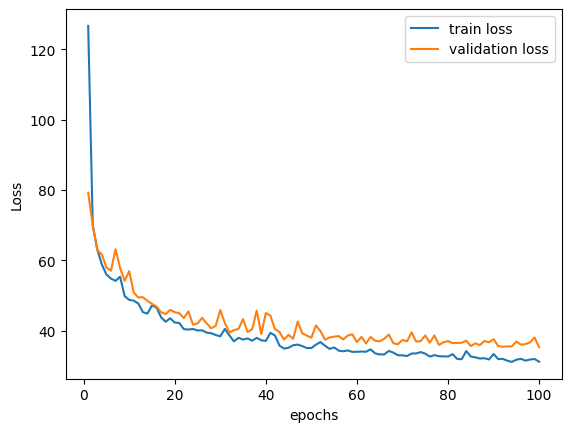

124/124 [==============================] - 0s 3ms/step

Final Validation MAE: 35.2853209425896 from tf: 35.2853209425896
Final Validation RMSE: 88.89185448225177 from tf: 88.89185448225186
Final Validation R-Squared: 0.9511490818392677 from tf: 0.9511490818392676
Final Validation NMBE: -3.449022253899993 from tf: -3.449022253899993

Final Test  MAE: 32.998725508561535 from tf: 32.998725508561535
Final Test  RMSE: 89.84310725695167 from tf: 89.8431072569517
Final Test  R-Squared: 0.9468858538741579 from tf: 0.9468858538741577
Final Test  NMBE: -3.0581399426183835 from tf: -3.0581399426183835

******************************************************************************************************************************************************
num_nodes_L1:300, num_nodes_L2:200, num_nodes_L3:30, learning_rate:0.01, batch_size:500
124/124 [==============================] - 0s 2ms/step - loss: 32.9260 - mae: 32.9260


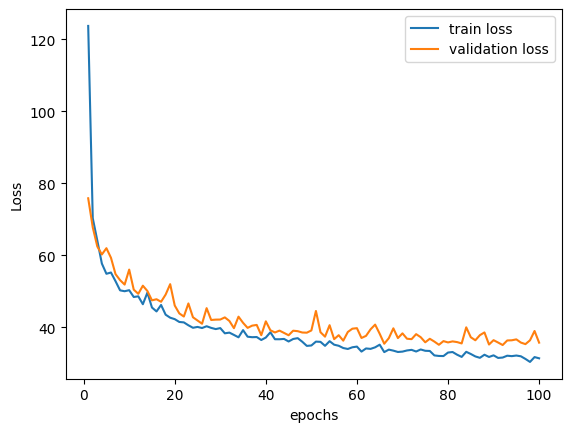

124/124 [==============================] - 0s 2ms/step

Final Validation MAE: 35.74314762871022 from tf: 35.74314762871022
Final Validation RMSE: 88.42032363609695 from tf: 88.42032363609695
Final Validation R-Squared: 0.9516659710541127 from tf: 0.9516659710541125
Final Validation NMBE: 2.8012919290592713 from tf: 2.8012919290592717

Final Test  MAE: 32.92601479394251 from tf: 32.92601479394251
Final Test  RMSE: 85.83580437601802 from tf: 85.83580437601802
Final Test  R-Squared: 0.9515183224013711 from tf: 0.951518322401371
Final Test  NMBE: 3.268353060698787 from tf: 3.2683530606987867

******************************************************************************************************************************************************
num_nodes_L1:300, num_nodes_L2:250, num_nodes_L3:25, learning_rate:0.01, batch_size:500
124/124 [==============================] - 0s 2ms/step - loss: 35.6817 - mae: 35.6817
*******************************************************************************

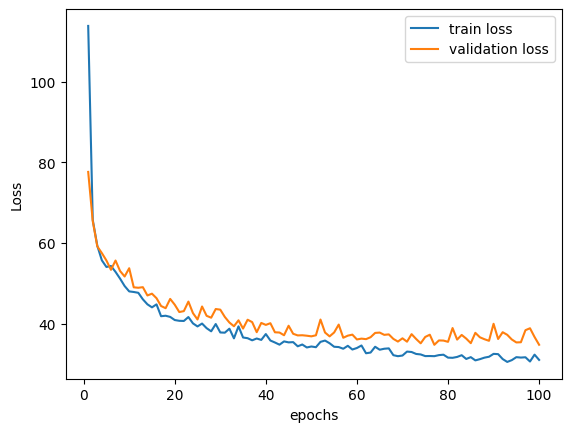

124/124 [==============================] - 0s 2ms/step

Final Validation MAE: 34.83117781585343 from tf: 34.83117781585343
Final Validation RMSE: 88.80313483793513 from tf: 88.80313483793515
Final Validation R-Squared: 0.9512465457360244 from tf: 0.9512465457360244
Final Validation NMBE: -3.054204244583785 from tf: -3.054204244583785

Final Test  MAE: 31.874377137903874 from tf: 31.874377137903874
Final Test  RMSE: 86.67506440493679 from tf: 86.67506440493678
Final Test  R-Squared: 0.9505656278563203 from tf: 0.9505656278563202
Final Test  NMBE: -2.5819456627857984 from tf: -2.5819456627857984



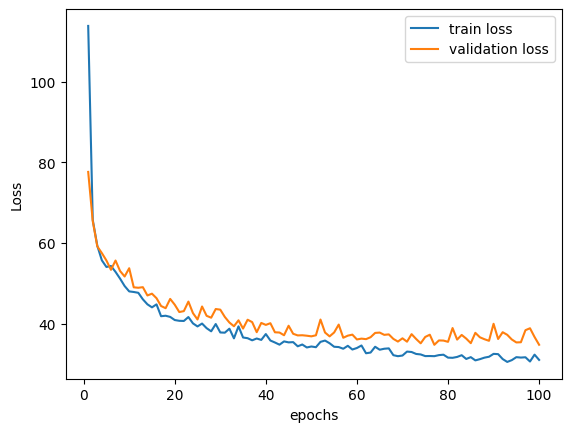

124/124 [==============================] - 0s 3ms/step

Final Validation MAE: 34.83117781585343 from tf: 34.83117781585343
Final Validation RMSE: 88.80313483793513 from tf: 88.80313483793515
Final Validation R-Squared: 0.9512465457360244 from tf: 0.9512465457360244
Final Validation NMBE: -3.054204244583785 from tf: -3.054204244583785

Final Test  MAE: 31.874377137903874 from tf: 31.874377137903874
Final Test  RMSE: 86.67506440493679 from tf: 86.67506440493678
Final Test  R-Squared: 0.9505656278563203 from tf: 0.9505656278563202
Final Test  NMBE: -2.5819456627857984 from tf: -2.5819456627857984

******************************************************************************************************************************************************
num_nodes_L1:350, num_nodes_L2:250, num_nodes_L3:30, learning_rate:0.01, batch_size:500
124/124 [==============================] - 0s 2ms/step - loss: 33.7031 - mae: 33.7031
*************************************************************************

In [ ]:
'''
1st Attempt
Best Model Details on validation for model 1: {'num_nodes_L1': 350, 'num_nodes_L2': 200, 'num_nodes_L3': 30, 'learning_rate': 0.01, 'batch_size': 128,
'Validation_MAE': 31.270356091457092, 'Test_MAE:': 31.313096803219967, 'Validation R Squared': 0.9430882861415423, 'Test R Squared': 0.9357308173685686}

Best Model Details on test for model 1: {'num_nodes_L1': 350, 'num_nodes_L2': 200, 'num_nodes_L3': 30, 'learning_rate': 0.01, 'batch_size': 128,
'Validation_MAE': 31.270356091457092, 'Test_MAE:': 31.313096803219967, 'Validation R Squared': 0.9430882861415423, 'Test R Squared': 0.9357308173685686}

2nd Attempt

Best Model Details on validation for model 1: {'num_nodes_L1': 300, 'num_nodes_L2': 200, 'num_nodes_L3': 25, 'learning_rate': 0.01, 'batch_size': 128,
'Validation_MAE': 36.00894545578819, 'Test_MAE:': 35.07636181337859, 'Validation R Squared': 0.9266528401372975, 'Test R Squared': 0.9211743989366427}

Best Model Details on test for model 1: {'num_nodes_L1': 300, 'num_nodes_L2': 200, 'num_nodes_L3': 25, 'learning_rate': 0.01, 'batch_size': 128,
 'Validation_MAE': 36.00894545578819, 'Test_MAE:': 35.07636181337859, 'Validation R Squared': 0.9266528401372975, 'Test R Squared': 0.9211743989366427}

'''


epochs = 100
#l2_regularization=0.1
#dropout_rate=0.1

least_val_loss = float('inf')
least_val_loss_model = None
best_model_details_val = {}

least_test_loss = float('inf')
least_test_loss_model = None
best_model_details_test = {}

for batch_size in [1000,500]:           #150,128(tried), 200, 256,1
    for num_nodes_L1 in range(300, 351, 50):
        for num_nodes_L2 in [200,250]:
            for num_nodes_L3 in range (25,31, 5):
                for learning_rate in [0.01]:
                    print(f"num_nodes_L1:{num_nodes_L1}, num_nodes_L2:{num_nodes_L2}, num_nodes_L3:{num_nodes_L3}, learning_rate:{learning_rate}, batch_size:{batch_size}")
                    model, history = train_model(X_train, Y_train, num_nodes_L1, num_nodes_L2, num_nodes_L3, learning_rate, batch_size, epochs)    #l2_regularization /dropout_rate

                    val_loss = model.evaluate(X_dev, Y_dev)[0]  # Extracting the loss value from the list
                    test_loss = model.evaluate(X_test, Y_test)[0]  # Extracting the loss value from the list

                    if val_loss < least_val_loss:
                        least_val_loss = val_loss
                        least_val_loss_model = model
                        plot_history(history, method='seaborn')

                        y_dev_pred_S = model.predict(X_dev).flatten()
                        mae_validation, rmse_validation, r_squared_validation, nmbe_validation = calculate_metrics(Y_dev, y_dev_pred_S)
                        mae_tf_validation, rmse_tf_validation, r_squared_tf_validation, nmbe_tf_validation = calculate_metrics_tf(Y_dev, y_dev_pred_S)

                        y_test_pred_S = model.predict(X_test).flatten()
                        mae_test, rmse_test, r_squared_test, nmbe_test = calculate_metrics(Y_test, y_test_pred_S)
                        mae_tf_test, rmse_tf_test, r_squared_tf_test, nmbe_tf_test = calculate_metrics_tf(Y_test, y_test_pred_S)

                        best_model_details_val = {
                            "num_nodes_L1": num_nodes_L1,
                            "num_nodes_L2": num_nodes_L2,
                            "num_nodes_L3": num_nodes_L3,
                            "learning_rate": learning_rate,
                            "batch_size": batch_size,
                            "Validation_MAE": mae_validation,
                            "Test_MAE:": mae_test,
                            "Validation R Squared": r_squared_validation,
                            "Test R Squared": r_squared_test
                        }

                        print_metrices()


                    if test_loss < least_test_loss:
                        least_test_loss = test_loss
                        least_test_loss_model = model
                        plot_history(history, method='seaborn')

                        y_dev_pred_S = model.predict(X_dev).flatten()
                        mae_validation, rmse_validation, r_squared_validation, nmbe_validation = calculate_metrics(Y_dev, y_dev_pred_S)
                        mae_tf_validation, rmse_tf_validation, r_squared_tf_validation, nmbe_tf_validation = calculate_metrics_tf(Y_dev, y_dev_pred_S)

                        y_test_pred_S = model.predict(X_test).flatten()
                        mae_test, rmse_test, r_squared_test, nmbe_test = calculate_metrics(Y_test, y_test_pred_S)
                        mae_tf_test, rmse_tf_test, r_squared_tf_test, nmbe_tf_test = calculate_metrics_tf(Y_test, y_test_pred_S)

                        best_model_details_test = {
                            "num_nodes_L1": num_nodes_L1,
                            "num_nodes_L2": num_nodes_L2,
                            "num_nodes_L3": num_nodes_L3,
                            "learning_rate": learning_rate,
                            "batch_size": batch_size,
                            "Validation_MAE": mae_validation,
                            "Test_MAE:": mae_test,
                            "Validation R Squared": r_squared_validation,
                            "Test R Squared": r_squared_test
                        }
                        print_metrices()

                    print('*' * 150)


In [ ]:
print("Best Model Details on validation for model 1:", best_model_details_val)
print("Best Model Details on test for model 1:", best_model_details_test)

Best Model Details on validation for model 1: {'num_nodes_L1': 350, 'num_nodes_L2': 200, 'num_nodes_L3': 25, 'learning_rate': 0.01, 'batch_size': 128, 'Validation_MAE': 32.92756029419465, 'Test_MAE:': 33.127799968359284, 'Validation R Squared': 0.951811242623767, 'Test R Squared': 0.9498814577047607}
Best Model Details on test for model 1: {'num_nodes_L1': 350, 'num_nodes_L2': 200, 'num_nodes_L3': 25, 'learning_rate': 0.01, 'batch_size': 128, 'Validation_MAE': 32.92756029419465, 'Test_MAE:': 33.127799968359284, 'Validation R Squared': 0.951811242623767, 'Test R Squared': 0.9498814577047607}


In [ ]:
import joblib

# Save the scaler to a file
joblib.dump(scaler, 'scaler.pkl')
least_test_loss_model.save('ON_Off_least_test_loss_model1 for robotics.h5')
#least_val_loss_model.save('least_val_loss_model1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



##Model 2

In [ ]:
def train_model2(X_train,Y_train,num_nodes_L1,num_nodes_L2,num_nodes_L3,num_nodes_L4,learning_rate,batch_size,epochs):
  Model= tf.keras.Sequential([
    tf.keras.layers.Dense(num_nodes_L1, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(num_nodes_L2, activation='relu'),
    tf.keras.layers.Dense(num_nodes_L3, activation='relu'),
    tf.keras.layers.Dense(num_nodes_L4, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
  ])

  optimizer = Adam(learning_rate = learning_rate)

  # Compile the model with mean absolute error as the loss function and MAE as a metric

  Model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])
  history = Model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_dev, Y_dev),verbose=0)
  return Model,history


In [ ]:
from tensorflow.keras import regularizers

def train_model2(X_train, Y_train, num_nodes_L1, num_nodes_L2, num_nodes_L3, num_nodes_L4, learning_rate, batch_size, epochs, l2_regularization):
    # Build the model with L2 regularization
    Model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_nodes_L1, activation='relu', input_shape=(X_train.shape[1],),
                              kernel_regularizer=regularizers.l2(l2_regularization)),
        tf.keras.layers.Dense(num_nodes_L2, activation='relu',
                              kernel_regularizer=regularizers.l2(l2_regularization)),
        tf.keras.layers.Dense(num_nodes_L3, activation='relu',
                              kernel_regularizer=regularizers.l2(l2_regularization)),
        tf.keras.layers.Dense(num_nodes_L4, activation='relu',
                              kernel_regularizer=regularizers.l2(l2_regularization)),  # Additional hidden layer
        tf.keras.layers.Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model with mean absolute error as the loss function and MAE as a metric
    Model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

    history = Model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_dev, Y_dev), verbose=0)
    return Model, history


num_nodes_L1:250, num_nodes_L2:250, num_nodes_L3:120, num_nodes_L4:15, learning_rate:0.01, batch_size:128
206/206 [==============================] - 0s 2ms/step - loss: 40.1982 - mae: 36.3445


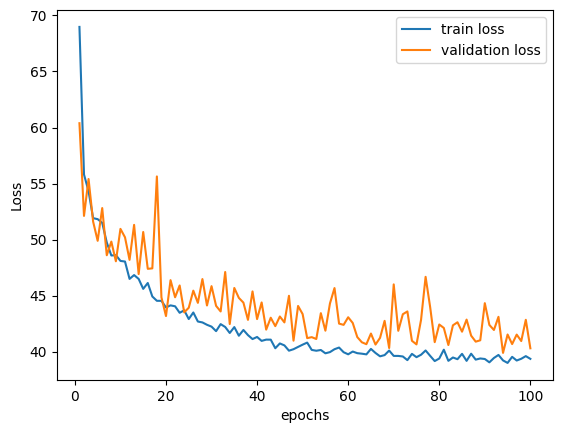

206/206 [==============================] - 0s 2ms/step

Final Validation MAE: 36.44661520020236 from tf: 36.44661520020236
Final Validation RMSE: 106.96191541417284 from tf: 106.96191541417285
Final Validation R-Squared: 0.9245664361145787 from tf: 0.9245664361145786
Final Validation NMBE: -6.700447783536763 from tf: -6.700447783536763

Final Test  MAE: 36.34450613038593 from tf: 36.34450613038593
Final Test  RMSE: 112.64338808790745 from tf: 112.64338808790745
Final Test  R-Squared: 0.9155014941871698 from tf: 0.9155014941871696
Final Test  NMBE: -6.106524800463862 from tf: -6.106524800463862



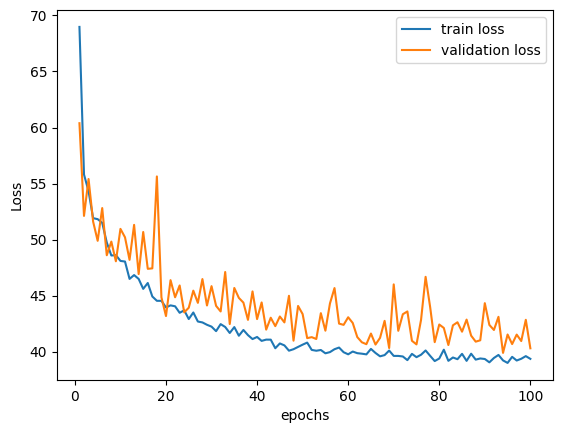

206/206 [==============================] - 0s 2ms/step

Final Validation MAE: 36.44661520020236 from tf: 36.44661520020236
Final Validation RMSE: 106.96191541417284 from tf: 106.96191541417285
Final Validation R-Squared: 0.9245664361145787 from tf: 0.9245664361145786
Final Validation NMBE: -6.700447783536763 from tf: -6.700447783536763

Final Test  MAE: 36.34450613038593 from tf: 36.34450613038593
Final Test  RMSE: 112.64338808790745 from tf: 112.64338808790745
Final Test  R-Squared: 0.9155014941871698 from tf: 0.9155014941871696
Final Test  NMBE: -6.106524800463862 from tf: -6.106524800463862

******************************************************************************************************************************************************
num_nodes_L1:250, num_nodes_L2:250, num_nodes_L3:120, num_nodes_L4:20, learning_rate:0.01, batch_size:128
206/206 [==============================] - 1s 3ms/step - loss: 41.1053 - mae: 37.6016
*******************************************************

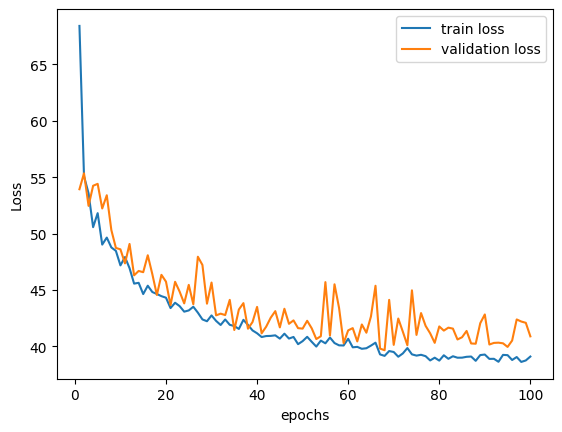

206/206 [==============================] - 0s 2ms/step

Final Validation MAE: 37.51573207390486 from tf: 37.515732073904864
Final Validation RMSE: 110.50981629379694 from tf: 110.50981629379694
Final Validation R-Squared: 0.9194792154677118 from tf: 0.9194792154677117
Final Validation NMBE: -3.484495825267729 from tf: -3.484495825267729

Final Test  MAE: 36.134441914965066 from tf: 36.134441914965066
Final Test  RMSE: 110.27144076660568 from tf: 110.27144076660566
Final Test  R-Squared: 0.9190226206182277 from tf: 0.9190226206182277
Final Test  NMBE: -3.3910791007165404 from tf: -3.3910791007165404

******************************************************************************************************************************************************
num_nodes_L1:250, num_nodes_L2:300, num_nodes_L3:150, num_nodes_L4:15, learning_rate:0.01, batch_size:128
206/206 [==============================] - 1s 3ms/step - loss: 40.7403 - mae: 37.0558
**************************************************

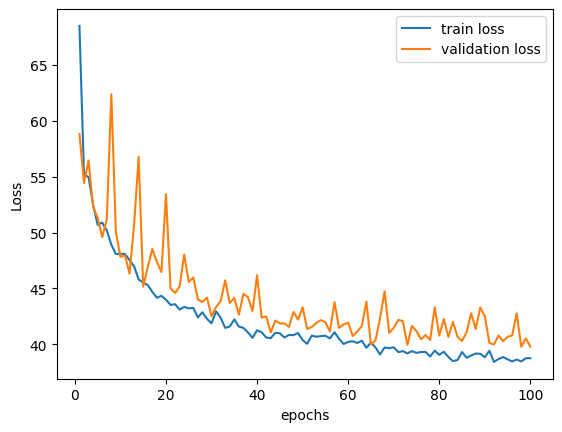

206/206 [==============================] - 1s 4ms/step

Final Validation MAE: 36.31395741800427 from tf: 36.31395741800427
Final Validation RMSE: 103.91777388633565 from tf: 103.91777388633564
Final Validation R-Squared: 0.9287990229470615 from tf: 0.9287990229470614
Final Validation NMBE: -1.6019395519178723 from tf: -1.6019395519178723

Final Test  MAE: 35.90868521789315 from tf: 35.90868521789315
Final Test  RMSE: 108.70010176678609 from tf: 108.70010176678605
Final Test  R-Squared: 0.9213139904313451 from tf: 0.9213139904313451
Final Test  NMBE: -1.5692116882616531 from tf: -1.5692116882616531



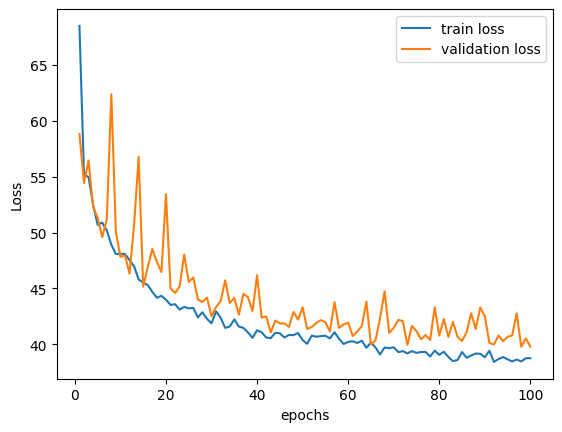

206/206 [==============================] - 1s 3ms/step

Final Validation MAE: 36.31395741800427 from tf: 36.31395741800427
Final Validation RMSE: 103.91777388633565 from tf: 103.91777388633564
Final Validation R-Squared: 0.9287990229470615 from tf: 0.9287990229470614
Final Validation NMBE: -1.6019395519178723 from tf: -1.6019395519178723

Final Test  MAE: 35.90868521789315 from tf: 35.90868521789315
Final Test  RMSE: 108.70010176678609 from tf: 108.70010176678605
Final Test  R-Squared: 0.9213139904313451 from tf: 0.9213139904313451
Final Test  NMBE: -1.5692116882616531 from tf: -1.5692116882616531

******************************************************************************************************************************************************
num_nodes_L1:250, num_nodes_L2:350, num_nodes_L3:150, num_nodes_L4:15, learning_rate:0.01, batch_size:128
206/206 [==============================] - 1s 2ms/step - loss: 39.8686 - mae: 36.2003
***************************************************

In [ ]:
''' 1st attempt





'''
epochs = 100
l2_regularization = 0.01

least_val_loss = float('inf')
least_val_loss_model2 = None
best_model_details_val2 = {}

least_test_loss = float('inf')
least_test_loss_model2 = None
best_model_details_test2 = {}

for batch_size in [128]:           #150(tried), 200, 256
  for num_nodes_L1 in range(250, 351, 50):
      for num_nodes_L2 in range(250,351, 50):
          for num_nodes_L3 in range(120, 171, 30):
              for num_nodes_L4 in range(15, 21, 5):
                  for learning_rate in [0.01]:

                        print(f"num_nodes_L1:{num_nodes_L1}, num_nodes_L2:{num_nodes_L2}, num_nodes_L3:{num_nodes_L3}, num_nodes_L4:{num_nodes_L4}, learning_rate:{learning_rate}, batch_size:{batch_size}")
                        model, history = train_model2(X_train, Y_train, num_nodes_L1, num_nodes_L2, num_nodes_L3, num_nodes_L4, learning_rate, batch_size, epochs,l2_regularization)


                        val_loss = model.evaluate(X_dev, Y_dev)[0]  # Extracting the loss value from the list
                        test_loss = model.evaluate(X_test, Y_test)[0]  # Extracting the loss value from the list

                        if val_loss < least_val_loss:
                            least_val_loss = val_loss
                            least_val_loss_model2 = model
                            plot_history(history, method='seaborn')

                            y_dev_pred_S = model.predict(X_dev).flatten()
                            mae_validation, rmse_validation, r_squared_validation, nmbe_validation = calculate_metrics(Y_dev, y_dev_pred_S)
                            mae_tf_validation, rmse_tf_validation, r_squared_tf_validation, nmbe_tf_validation = calculate_metrics_tf(Y_dev, y_dev_pred_S)

                            y_test_pred_S = model.predict(X_test).flatten()
                            mae_test, rmse_test, r_squared_test, nmbe_test = calculate_metrics(Y_test, y_test_pred_S)
                            mae_tf_test, rmse_tf_test, r_squared_tf_test, nmbe_tf_test = calculate_metrics_tf(Y_test, y_test_pred_S)

                            best_model_details_val2 = {
                                "num_nodes_L1": num_nodes_L1,
                                "num_nodes_L2": num_nodes_L2,
                                "num_nodes_L3": num_nodes_L3,
                                "num_nodes_L4": num_nodes_L4,
                                "learning_rate": learning_rate,
                                "batch_size": batch_size,
                                "Validation_MAE": mae_validation,
                                "Test_MAE:": mae_test,
                                "Validation R Squared": r_squared_validation,
                                "Test R Squared": r_squared_test
                            }

                            print_metrices()


                        if test_loss < least_test_loss:
                            least_test_loss = test_loss
                            least_test_loss_model2 = model
                            plot_history(history, method='seaborn')

                            y_dev_pred_S = model.predict(X_dev).flatten()
                            mae_validation, rmse_validation, r_squared_validation, nmbe_validation = calculate_metrics(Y_dev, y_dev_pred_S)
                            mae_tf_validation, rmse_tf_validation, r_squared_tf_validation, nmbe_tf_validation = calculate_metrics_tf(Y_dev, y_dev_pred_S)

                            y_test_pred_S = model.predict(X_test).flatten()
                            mae_test, rmse_test, r_squared_test, nmbe_test = calculate_metrics(Y_test, y_test_pred_S)
                            mae_tf_test, rmse_tf_test, r_squared_tf_test, nmbe_tf_test = calculate_metrics_tf(Y_test, y_test_pred_S)

                            best_model_details_test2 = {
                                "num_nodes_L1": num_nodes_L1,
                                "num_nodes_L2": num_nodes_L2,
                                "num_nodes_L3": num_nodes_L3,
                                "num_nodes_L4": num_nodes_L4,
                                "learning_rate": learning_rate,
                                "batch_size": batch_size,
                                "Validation_MAE": mae_validation,
                                "Test_MAE:": mae_test,
                                "Validation R Squared": r_squared_validation,
                                "Test R Squared": r_squared_test
                            }
                            print_metrices()

                        print('*' * 150)







In [ ]:
print("Best Model Details on validation for model 2:", best_model_details_val2)
print("Best Model Details on test for model 2:", best_model_details_test2)



Best Model Details on validation for model 2: {'num_nodes_L1': 250, 'num_nodes_L2': 350, 'num_nodes_L3': 120, 'num_nodes_L4': 20, 'learning_rate': 0.01, 'batch_size': 128, 'Validation_MAE': 36.31395741800427, 'Test_MAE:': 35.90868521789315, 'Validation R Squared': 0.9287990229470615, 'Test R Squared': 0.9213139904313451}
Best Model Details on test for model 2: {'num_nodes_L1': 250, 'num_nodes_L2': 350, 'num_nodes_L3': 120, 'num_nodes_L4': 20, 'learning_rate': 0.01, 'batch_size': 128, 'Validation_MAE': 36.31395741800427, 'Test_MAE:': 35.90868521789315, 'Validation R Squared': 0.9287990229470615, 'Test R Squared': 0.9213139904313451}


In [ ]:
least_test_loss_model2.save('ON_Off_least_test_loss_model2.h5')
#least_val_loss_model2.save('least_val_loss_model2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##Predictions from Least Lost Models

In [ ]:
y_test_pred = least_val_loss_model.predict(X_test).flatten()
mae_test,rmse_test, r_squared_test, nmbe_test = calculate_metrics(Y_test, y_test_pred)
mae_tf_test,rmse_tf_test, r_squared_tf_test, nmbe_tf_test = calculate_metrics_tf(Y_test, y_test_pred)


print("Final Test MAE:", mae_test,'from tf:',mae_tf_test)
print("Final Test RMSE:", rmse_test,'from tf:',rmse_tf_test)
print("Final Test R-Squared:", r_squared_test,'from tf:',mae_tf_test)
print("Final Test NMBE:", nmbe_test,'from tf:',nmbe_tf_test)

#Plot the result

# Predict on test data
Y_test_pred = least_val_loss_model.predict(X_test)

# Create a DataFrame with the predicted output and actual values
data = pd.DataFrame({'Data Point': range(len(Y_test)),
                     'Estimated Output': Y_test_pred.flatten(),
                     'Actual Value': Y_test})

# Melt the DataFrame to long format
data_melted = data.melt(id_vars='Data Point', var_name='Variable', value_name='Value')

# Plotting using Plotly Express
fig = px.line(data_melted, x='Data Point', y='Value', color='Variable', line_shape='linear',
              labels={'Value': 'Value', 'Data Point': 'Data Point'},
              title='Estimated Output vs Actual Value on Test Data leat val model')
fig.update_layout(xaxis_title='Data Point', yaxis_title='Value')
fig.show()



2/2 [==============================] - 0s 4ms/step
Final Test MAE: 61.89379660458034 from tf: 61.89379660458035
Final Test RMSE: 117.40862351649855 from tf: 117.40862351649855
Final Test R-Squared: 0.9390966324844361 from tf: 61.89379660458035
Final Test NMBE: 2.494416684825457 from tf: 2.494416684825457
2/2 [==============================] - 0s 4ms/step


In [ ]:
y_test_pred = least_test_loss_model.predict(X_test).flatten()
mae_test,rmse_test, r_squared_test, nmbe_test = calculate_metrics(Y_test, y_test_pred)
mae_tf_test,rmse_tf_test, r_squared_tf_test, nmbe_tf_test = calculate_metrics_tf(Y_test, y_test_pred)


print("Final Test MAE:", mae_test,'from tf:',mae_tf_test)
print("Final Test RMSE:", rmse_test,'from tf:',rmse_tf_test)
print("Final Test R-Squared:", r_squared_test,'from tf:',mae_tf_test)
print("Final Test NMBE:", nmbe_test,'from tf:',nmbe_tf_test)

#Plot the result

# Predict on test data
Y_test_pred = least_test_loss_model.predict(X_test)

# Create a DataFrame with the predicted output and actual values
data = pd.DataFrame({'Data Point': range(len(Y_test)),
                     'Estimated Output': Y_test_pred.flatten(),
                     'Actual Value': Y_test})

# Melt the DataFrame to long format
data_melted = data.melt(id_vars='Data Point', var_name='Variable', value_name='Value')

# Plotting using Plotly Express
fig = px.line(data_melted, x='Data Point', y='Value', color='Variable', line_shape='linear',
              labels={'Value': 'Value', 'Data Point': 'Data Point'},
              title='Estimated Output vs Actual Value on Test Data least test model')
fig.update_layout(xaxis_title='Data Point', yaxis_title='Value')
fig.show()



2/2 [==============================] - 0s 4ms/step
Final Test MAE: 53.616347036149776 from tf: 53.61634703614977
Final Test RMSE: 94.18471583286278 from tf: 94.18471583286276
Final Test R-Squared: 0.9608075712678189 from tf: 53.61634703614977
Final Test NMBE: -0.2950256698766337 from tf: -0.2950256698766335
2/2 [==============================] - 0s 4ms/step


# **After Getting Best Model**

In [ ]:
# Load the dataset
dataFrame = pd.read_csv('/content/Robotics_Lab_Final_60T_Simulation_2023-01-01 00-10-00_to_2023-12-31 23-10-00.csv')
dataFrame.head()

,DateTime,Day_of_year,Time_of_day,Time,Day_of_year_normalized,Time_of_day_normalized,Outdoor_Temp_°C,Outdoor_Humidity_%,Outdoor_SolarRadiation_W/m2,Indoor_Temp_°C,Indoor_Humidity_%,FloorNumber,Volume_of_Room_m3,AC_type,Rated_wattage,BTU,Energy_Efficiency_Ratio,Operating_state,Power_W
0,2023-01-01 00:10:00,1,0,10,0.0,0.000,23.333,84.50,0.0,23.452,84.098,2,101.752,0,2480,24000,0.815,1,4.0
1,2023-01-01 01:10:00,1,1,70,0.0,0.042,22.683,89.00,0.0,23.124,86.155,2,101.752,0,2480,24000,0.815,1,4.0
2,2023-01-01 02:10:00,1,2,130,0.0,0.083,21.517,97.50,0.0,22.344,92.599,2,101.752,0,2480,24000,0.815,1,4.0
3,2023-01-01 03:10:00,1,3,190,0.0,0.125,21.450,93.00,0.0,21.931,90.674,2,101.752,0,2480,24000,0.815,1,4.0
4,2023-01-01 04:10:00,1,4,250,0.0,0.167,20.475,89.75,0.0,21.587,84.503,2,101.752,0,2480,24000,0.815,1,4.0


Data set without mixing

In [ ]:
# Columns to keep constant
constant_columns = ["Operating_state"]

# Columns to scale
columns_to_scale = ["Time_of_day", 'Day_of_year', 'Outdoor_Temp_°C', 'Outdoor_Humidity_%', 'Outdoor_SolarRadiation_W/m2',
                    'Indoor_Temp_°C', 'Indoor_Humidity_%', "Volume_of_Room_m3", "Rated_wattage","Energy_Efficiency_Ratio", "BTU"]  # 'WindSpeed' ,"Time",

# Separate constant columns
constant_df = dataFrame[constant_columns]

# Load scaling parameters
scaler = StandardScaler()
scaler.fit(dataFrame[columns_to_scale])
scaled_df= scaler.transform(dataFrame[columns_to_scale])
# Convert scaled_df to a DataFrame
scaled_df = pd.DataFrame(scaled_df, columns=columns_to_scale)

# Concatenate constant columns with scaled data
X = pd.concat([constant_df, scaled_df], axis=1)

# Extract date from the "DateTime" column of dataFrame
date_column = dataFrame["DateTime"]

# Add the extracted date column as the first column of X DataFrame
X.insert(0, "Date", date_column)

# Extract the target variable y
Y = dataFrame['Power_W']

# Calculate the lengths of each set
total_length = len(dataFrame)
train_length = int(total_length * 0.2)
dev_length = test_length = (total_length - train_length) // 2

# Split the data into training, development, and test sets
X_train = X[:train_length]
Y_train = Y[:train_length]

X_dev = X[train_length:train_length + dev_length]
Y_dev = Y[train_length:train_length + dev_length]

X_test = X[train_length + dev_length:]
Y_test = Y[train_length + dev_length:]


In [ ]:
X_train.head(20)

,Date,Operating_state,Time_of_day,Day_of_year,Outdoor_Temp_°C,Outdoor_Humidity_%,Outdoor_SolarRadiation_W/m2,Indoor_Temp_°C,Indoor_Humidity_%,Volume_of_Room_m3,Rated_wattage,Energy_Efficiency_Ratio,BTU
0,2023-01-01 00:10:00,1,-1.661325,-1.727312,-1.817308,0.243233,-0.731046,-1.911047,-0.501128,2.842171e-14,0.0,3.330669e-16,0.0
1,2023-01-01 01:10:00,1,-1.516862,-1.727312,-2.079488,0.661896,-0.731046,-2.161622,-0.268962,2.842171e-14,0.0,3.330669e-16,0.0
2,2023-01-01 02:10:00,1,-1.372399,-1.727312,-2.549800,1.452702,-0.731046,-2.757499,0.458348,2.842171e-14,0.0,3.330669e-16,0.0
3,2023-01-01 03:10:00,1,-1.227936,-1.727312,-2.576825,1.034040,-0.731046,-3.073009,0.241080,2.842171e-14,0.0,3.330669e-16,0.0
4,2023-01-01 04:10:00,1,-1.083473,-1.727312,-2.970096,0.731673,-0.731046,-3.335806,-0.455417,2.842171e-14,0.0,3.330669e-16,0.0
5,2023-01-01 05:10:00,1,-0.939010,-1.727312,-2.734940,0.413768,-0.731046,-3.257883,-0.675507,2.842171e-14,0.0,3.330669e-16,0.0
6,2023-01-01 06:10:00,1,-0.794547,-1.727312,-2.055690,-0.276187,-0.632825,-2.792641,-0.817041,2.842171e-14,0.0,3.330669e-16,0.0
7,2023-01-01 07:10:00,1,-0.650084,-1.727312,-1.424037,-1.144586,0.258710,-1.755203,-1.745366,2.842171e-14,0.0,3.330669e-16,0.0
8,2023-01-01 08:10:00,1,-0.505621,-1.727312,-0.633864,-1.299584,1.030142,-1.215093,-1.607895,2.842171e-14,0.0,3.330669e-16,0.0
9,2023-01-01 09:10:00,2,-0.361158,-1.727312,0.243433,-2.516868,1.585336,0.197442,-2.831365,2.842171e-14,0.0,3.330669e-16,0.0


In [ ]:
'''# Build a model
DenseModel = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),

    tf.keras.layers.Dense(1, activation='linear')  # Output layer
])
'''

DenseModel=tf.keras.models.load_model('/content/ON_Off_least_test_loss_model2.h5')
DenseModel.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_113 (Dense)           (None, 250)               3250      
                                                                 
 dense_114 (Dense)           (None, 350)               87850     
                                                                 
 dense_115 (Dense)           (None, 120)               42120     
                                                                 
 dense_116 (Dense)           (None, 20)                2420      
                                                                 
 dense_117 (Dense)           (None, 1)                 21        
                                                                 
Total params: 135661 (529.93 KB)
Trainable params: 135661 (529.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Adjust the initial learning rate
learning_rate= 0.01  # Increase the initial learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with mean absolute error as the loss function and MAE as a metric

DenseModel.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

'''
DenseModel.compile(optimizer=tf.keras.optimizers.Aadam(lr=learning_rate),loss= tf.keras.losses.mae, metrics=['mae'])'''

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Train the Model
history = DenseModel.fit(X_train.iloc[:,1:], Y_train, batch_size=128, epochs=100, validation_data=(X_dev.iloc[:,1:], Y_dev)) #,callbacks=[early_stopping]

# Extracting training loss and validation loss from history
train_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Creating a DataFrame for plotting
history_df = pd.DataFrame({'Epoch': range(1, len(train_loss) + 1),
                           'Training Loss': train_loss,
                           'Validation Loss': validation_loss})




# Plotting the learning curve using Plotly Express
fig = px.line(history_df, x='Epoch', y=['Training Loss', 'Validation Loss'],
              labels={'value': 'Loss', 'variable': 'Loss Type'},
              title='Learning Curve: Training and Validation Loss Over Epochs')
fig.show()



Epoch 1/100
48/48 [==============================] - 1s 11ms/step - loss: 114.8109 - mae: 111.0343 - val_loss: 197.1501 - val_mae: 193.3901
Epoch 2/100
48/48 [==============================] - 0s 7ms/step - loss: 112.7357 - mae: 108.9703 - val_loss: 184.6256 - val_mae: 180.8416
Epoch 3/100
48/48 [==============================] - 0s 7ms/step - loss: 113.4861 - mae: 109.7074 - val_loss: 231.5322 - val_mae: 227.7502
Epoch 4/100
48/48 [==============================] - 0s 7ms/step - loss: 112.3702 - mae: 108.5901 - val_loss: 220.5966 - val_mae: 216.8169
Epoch 5/100
48/48 [==============================] - 0s 6ms/step - loss: 113.2007 - mae: 109.4076 - val_loss: 191.3174 - val_mae: 187.5178
Epoch 6/100
48/48 [==============================] - 0s 7ms/step - loss: 113.4029 - mae: 109.6302 - val_loss: 188.4103 - val_mae: 184.6411
Epoch 7/100
48/48 [==============================] - 0s 7ms/step - loss: 111.8432 - mae: 108.0624 - val_loss: 204.0074 - val_mae: 200.2104
Epoch 8/100
48/48 [=======

In [ ]:
loaded_model=least_test_loss_model

Training Accuracy

In [ ]:
y_train_pred = loaded_model.predict(X_train.iloc[:, 1:]).flatten()
mae_test,rmse_test, r_squared_test, nmbe_test = calculate_metrics(Y_train, y_train_pred)
mae_tf_test,rmse_tf_test, r_squared_tf_test, nmbe_tf_test = calculate_metrics_tf(Y_train, y_train_pred)


print("Final Train MAE:", mae_test,'from tf:',mae_tf_test)
print("Final Train RMSE:", rmse_test,'from tf:',rmse_tf_test)
print("Final Train R-Squared:", r_squared_test,'from tf:',r_squared_tf_test)
print("Final Train NMBE:", nmbe_test,'from tf:',nmbe_tf_test)

#Plot the result

# Predict on test data


# Create a DataFrame with the predicted output and actual values
data = pd.DataFrame({'Date': X_train.iloc[:,0],
                     'Estimated Output': y_train_pred.flatten(),
                     'Actual Value': Y_train})

# Melt the DataFrame to long format
data_melted = data.melt(id_vars='Date', var_name='Variable', value_name='Value')

# Plotting using Plotly Express
fig = px.line(data_melted, x='Date', y='Value', color='Variable', line_shape='linear',
              labels={'Value': 'Power (W)', 'Date': 'Date'},
              title='Estimated Output vs Actual Value')
fig.update_layout(xaxis_title='Date', yaxis_title='Power (W)')  # Change y-axis label
fig.show()

'''
RA Room

Final Train MAE: 86.97520656843417 from tf: 86.97520656843419
Final Train RMSE: 134.63634072714925 from tf: 134.63634072714927
Final Train R-Squared: 0.9180577943243665 from tf: 0.9180577943243665
Final Train NMBE: -0.5216097145889242 from tf: -0.5216097145889242


'''


165/165 [==============================] - 0s 2ms/step
Final Train MAE: 86.97520656843417 from tf: 86.97520656843419
Final Train RMSE: 134.63634072714925 from tf: 134.63634072714927
Final Train R-Squared: 0.9180577943243665 from tf: 0.9180577943243665
Final Train NMBE: -0.5216097145889242 from tf: -0.5216097145889242


In [ ]:
y_train_pred = loaded_model.predict(X_train.iloc[:, 1:]).flatten()
mae_test,rmse_test, r_squared_test, nmbe_test = calculate_metrics(Y_train, y_train_pred)
mae_tf_test,rmse_tf_test, r_squared_tf_test, nmbe_tf_test = calculate_metrics_tf(Y_train, y_train_pred)


print("Final Train MAE:", mae_test,'from tf:',mae_tf_test)
print("Final Train RMSE:", rmse_test,'from tf:',rmse_tf_test)
print("Final Train R-Squared:", r_squared_test,'from tf:',r_squared_tf_test)
print("Final Train NMBE:", nmbe_test,'from tf:',nmbe_tf_test)

#Plot the result

# Predict on test data


# Create a DataFrame with the predicted output and actual values
data = pd.DataFrame({'Date': X_train.iloc[:,0],
                     'Estimated Output': y_train_pred.flatten(),
                     'Actual Value': Y_train})

# Melt the DataFrame to long format
data_melted = data.melt(id_vars='Date', var_name='Variable', value_name='Value')

# Plotting using Plotly Express
fig = px.line(data_melted, x='Date', y='Value', color='Variable', line_shape='linear',
              labels={'Value': 'Power (W)', 'Date': 'Date'},
              title='Estimated Output vs Actual Value')
fig.update_layout(xaxis_title='Date', yaxis_title='Power (W)')  # Change y-axis label
fig.show()

'''
RA Room

Final Train MAE: 86.97520656843417 from tf: 86.97520656843419
Final Train RMSE: 134.63634072714925 from tf: 134.63634072714927
Final Train R-Squared: 0.9180577943243665 from tf: 0.9180577943243665
Final Train NMBE: -0.5216097145889242 from tf: -0.5216097145889242


'''


55/55 [==============================] - 0s 2ms/step
Final Train MAE: 58.174692012521234 from tf: 58.174692012521234
Final Train RMSE: 135.81154953938204 from tf: 135.81154953938199
Final Train R-Squared: 0.8789144811708106 from tf: 0.8789144811708107
Final Train NMBE: 2.598674952724257 from tf: 2.5986749527242567


'\nRA Room\n\nFinal Train MAE: 86.97520656843417 from tf: 86.97520656843419\nFinal Train RMSE: 134.63634072714925 from tf: 134.63634072714927\nFinal Train R-Squared: 0.9180577943243665 from tf: 0.9180577943243665\nFinal Train NMBE: -0.5216097145889242 from tf: -0.5216097145889242\n\n\n'

In [ ]:
loaded_model.summary()

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_288 (Dense)           (None, 300)               3900      
                                                                 
 dense_289 (Dense)           (None, 250)               75250     
                                                                 
 dense_290 (Dense)           (None, 25)                6275      
                                                                 
 dense_291 (Dense)           (None, 1)                 26        
                                                                 
Total params: 85451 (333.79 KB)
Trainable params: 85451 (333.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Evaluate on Validation Data

In [ ]:
y_dev_pred = loaded_model.predict(X_dev.iloc[:, 1:]).flatten()
mae_test,rmse_test, r_squared_test, nmbe_test = calculate_metrics(Y_dev, y_dev_pred)
mae_tf_test,rmse_tf_test, r_squared_tf_test, nmbe_tf_test = calculate_metrics_tf(Y_dev, y_dev_pred)


print("Final Validation MAE:", mae_test,'from tf:',mae_tf_test)
print("Final Validation RMSE:", rmse_test,'from tf:',rmse_tf_test)
print("Final Validation R-Squared:", r_squared_test,'from tf:',r_squared_tf_test)
print("Final Validation NMBE:", nmbe_test,'from tf:',nmbe_tf_test)

#Plot the result

# Predict on test data


# Create a DataFrame with the predicted output and actual values
data = pd.DataFrame({'Date': X_dev.iloc[:,0],
                     'Estimated Output': y_dev_pred.flatten(),
                     'Actual Value': Y_dev})

# Melt the DataFrame to long format
data_melted = data.melt(id_vars='Date', var_name='Variable', value_name='Value')

# Plotting using Plotly Express
fig = px.line(data_melted, x='Date', y='Value', color='Variable', line_shape='linear',
              labels={'Value': 'Power (W)', 'Date': 'Date'},
              title='Estimated Output vs Actual Value')
fig.update_layout(xaxis_title='Date', yaxis_title='Power (W)')  # Change y-axis label
fig.show()



42/42 [==============================] - 0s 3ms/step
Final Validation MAE: 346.908877466376 from tf: 346.90887746637594
Final Validation RMSE: 494.7579195404342 from tf: 494.75791954043416
Final Validation R-Squared: -0.2813150923976271 from tf: -0.28131509239762686
Final Validation NMBE: -76.52348154544858 from tf: -76.52348154544856


Evaluate on Test Data

In [ ]:
y_test_pred = loaded_model.predict(X_test.iloc[:, 1:]).flatten()
mae_test,rmse_test, r_squared_test, nmbe_test = calculate_metrics(Y_test, y_test_pred)
mae_tf_test,rmse_tf_test, r_squared_tf_test, nmbe_tf_test = calculate_metrics_tf(Y_test, y_test_pred)


print("Final Test MAE:", mae_test,'from tf:',mae_tf_test)
print("Final Test RMSE:", rmse_test,'from tf:',rmse_tf_test)
print("Final Test R-Squared:", r_squared_test,'from tf:',r_squared_tf_test)
print("Final Test NMBE:", nmbe_test,'from tf:',nmbe_tf_test)

#Plot the result

# Predict on test data


# Create a DataFrame with the predicted output and actual values
data = pd.DataFrame({'Date': X_test.iloc[:,0],
                     'Estimated Output': y_test_pred.flatten(),
                     'Actual Value': Y_test})

# Melt the DataFrame to long format
data_melted = data.melt(id_vars='Date', var_name='Variable', value_name='Value')

# Plotting using Plotly Express
fig = px.line(data_melted, x='Date', y='Value', color='Variable', line_shape='linear',
              labels={'Value': 'Power (W)', 'Date': 'Date'},
              title='Estimated Output vs Actual Value')
fig.update_layout(xaxis_title='Date', yaxis_title='Power (W)')  # Change y-axis label
fig.show()



42/42 [==============================] - 0s 2ms/step
Final Test MAE: 355.08441874276593 from tf: 355.08441874276593
Final Test RMSE: 498.8619945087068 from tf: 498.8619945087068
Final Test R-Squared: -0.24082949347512428 from tf: -0.24082949347512406
Final Test NMBE: -78.09057732756776 from tf: -78.09057732756777


# **Get ideal leaning rate**

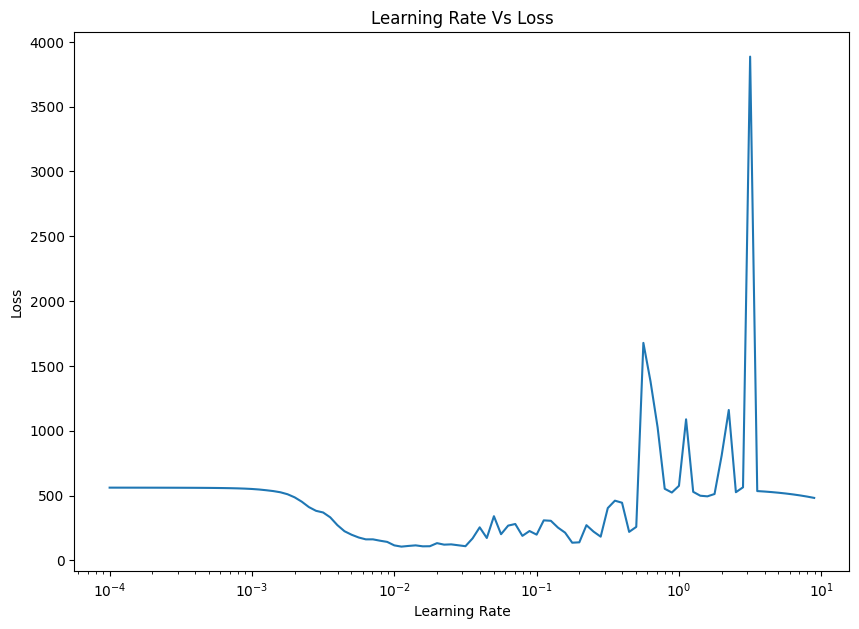

In [ ]:
# Build a model with dropout layers
Model_f = tf.keras.models.Sequential([
    tf.keras.layers.Dense(200, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Output layer
])



# Compile the model with mean absolute error as the loss function and MAE as a metric
Model_f.compile(optimizer="Adam", loss='mean_absolute_error', metrics=['mae'])
epochs=100
lr_scheduler=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4*10**(epoch/20) )
history = Model_f.fit(X_train, Y_train, batch_size=128, epochs=epochs,callbacks=[lr_scheduler], validation_data=(X_dev, Y_dev),verbose=0)

lrs=1e-4*(10**(tf.range(epochs)/20))

fig = px.line(x=lrs, y=history.history["loss"], log_x=True, labels={"x": "Learning Rate", "y": "Loss"}, title="Learning Rate Vs Loss")
fig.show()

Using performance Learning Rate schedular

In [ ]:
import tensorflow as tf
import numpy as np

# Define your model architecture
Model_f = tf.keras.models.Sequential([
    tf.keras.layers.Dense(200, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(15, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')  # Output layer
])

# Define the optimizer and the initial learning rate
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)

# Compile the model with mean absolute error as the loss function and MAE as a metric
Model_f.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

# Define the number of epochs
epochs = 100

# Define the custom callback for learning rate scheduling based on performance
class PerformanceLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, factor=0.5, patience=5, verbose=1, min_delta=1e-4):
        super(PerformanceLearningRateScheduler, self).__init__()
        self.factor = factor
        self.patience = patience
        self.verbose = verbose
        self.min_delta = min_delta
        self.wait = 0
        self.best_val_loss = np.Inf
        self.current_lr = initial_learning_rate

    def on_epoch_end(self, epoch, logs=None):
        current_val_loss = logs.get('val_loss')
        if current_val_loss is None:
            return

        if np.less(current_val_loss, self.best_val_loss - self.min_delta):
            self.best_val_loss = current_val_loss
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.current_lr *= self.factor
                if self.verbose > 0:
                    print(f'\nEpoch {epoch+1}: Learning rate reduced to {self.current_lr}.')
                self.wait = 0

        # Set the new learning rate
        tf.keras.backend.set_value(self.model.optimizer.lr, self.current_lr)

# Define the callback for performance-based learning rate scheduling
lr_scheduler = PerformanceLearningRateScheduler(factor=0.5, patience=5, verbose=1)

# Train the model
history = Model_f.fit(X_train, Y_train, batch_size=128, epochs=epochs, callbacks=[lr_scheduler],
                      validation_data=(X_dev, Y_dev), verbose=1)


y_dev_pred_S = Model_f.predict(X_dev).flatten()
mae_validation, rmse_validation, r_squared_validation, nmbe_validation = calculate_metrics(Y_dev, y_dev_pred_S)
mae_tf_validation, rmse_tf_validation, r_squared_tf_validation, nmbe_tf_validation = calculate_metrics_tf(Y_dev, y_dev_pred_S)

y_test_pred_S = Model_f.predict(X_test).flatten()
mae_test, rmse_test, r_squared_test, nmbe_test = calculate_metrics(Y_test, y_test_pred_S)
mae_tf_test, rmse_tf_test, r_squared_tf_test, nmbe_tf_test = calculate_metrics_tf(Y_test, y_test_pred_S)

print_metrices()


2/2 [==============================] - 0s 6ms/step

Final Validation MAE: 60.238640754045754 from tf: 60.238640754045754
Final Validation RMSE: 103.39665893298067 from tf: 103.39665893298067
Final Validation R-Squared: 0.9556180811403843 from tf: 0.9556180811403843
Final Validation NMBE: -3.7011372806893066 from tf: -3.7011372806893066

Final Test  MAE: 65.67049782562256 from tf: 65.67049782562256
Final Test  RMSE: 113.84144383195476 from tf: 113.84144383195475
Final Test  R-Squared: 0.9427412181908239 from tf: 0.9427412181908239
Final Test  NMBE: 0.9987906435501506 from tf: 0.9987906435501508



In [ ]:
# Create a DataFrame with the predicted output and actual values
data = pd.DataFrame({'Data Point': range(len(Y_test)),
                     'Estimated Output': y_test_pred_S.flatten(),
                     'Actual Value': Y_test})

# Melt the DataFrame to long format
data_melted = data.melt(id_vars='Data Point', var_name='Variable', value_name='Value')

# Plotting using Plotly Express
fig = px.line(data_melted, x='Data Point', y='Value', color='Variable', line_shape='linear',
              labels={'Value': 'Value', 'Data Point': 'Data Point'},
              title='Estimated Output vs Actual Value on Test Data least test model')
fig.update_layout(xaxis_title='Data Point', yaxis_title='Value')
fig.show()

